

*** Info ***
'execute_on' parameter specified in [Outputs] block is ignored for object 'checkpoint'.
Define this object in its own sub-block of [Outputs] to modify its execution schedule.
Framework Information:
MOOSE Version:           git commit a7c0463552 on 2025-03-16
LibMesh Version:         
PETSc Version:           3.22.1
SLEPc Version:           3.22.1
Current Time:            Sun Apr 13 15:16:45 2025
Executable Timestamp:    Sat Mar 29 19:51:20 2025

Input File(s):
  /Users/windy/projects/borehole1/step1_tmp.i

Checkpoint:
  Wall Time Interval:      Every 3600 s
  User Checkpoint:         Disabled
  # Checkpoints Kept:      2
  Execute On:              TIMESTEP_END 

Parallelism:
  Num Processors:          1
  Num Threads:             1

Mesh: 
  Parallel Type:           replicated
  Mesh Dimension:          2
  Spatial Dimension:       2
  Nodes:                   4137
  Elems:                   8084
  Num Subdomains:          1

Nonlinear System:
  Num DOFs:                

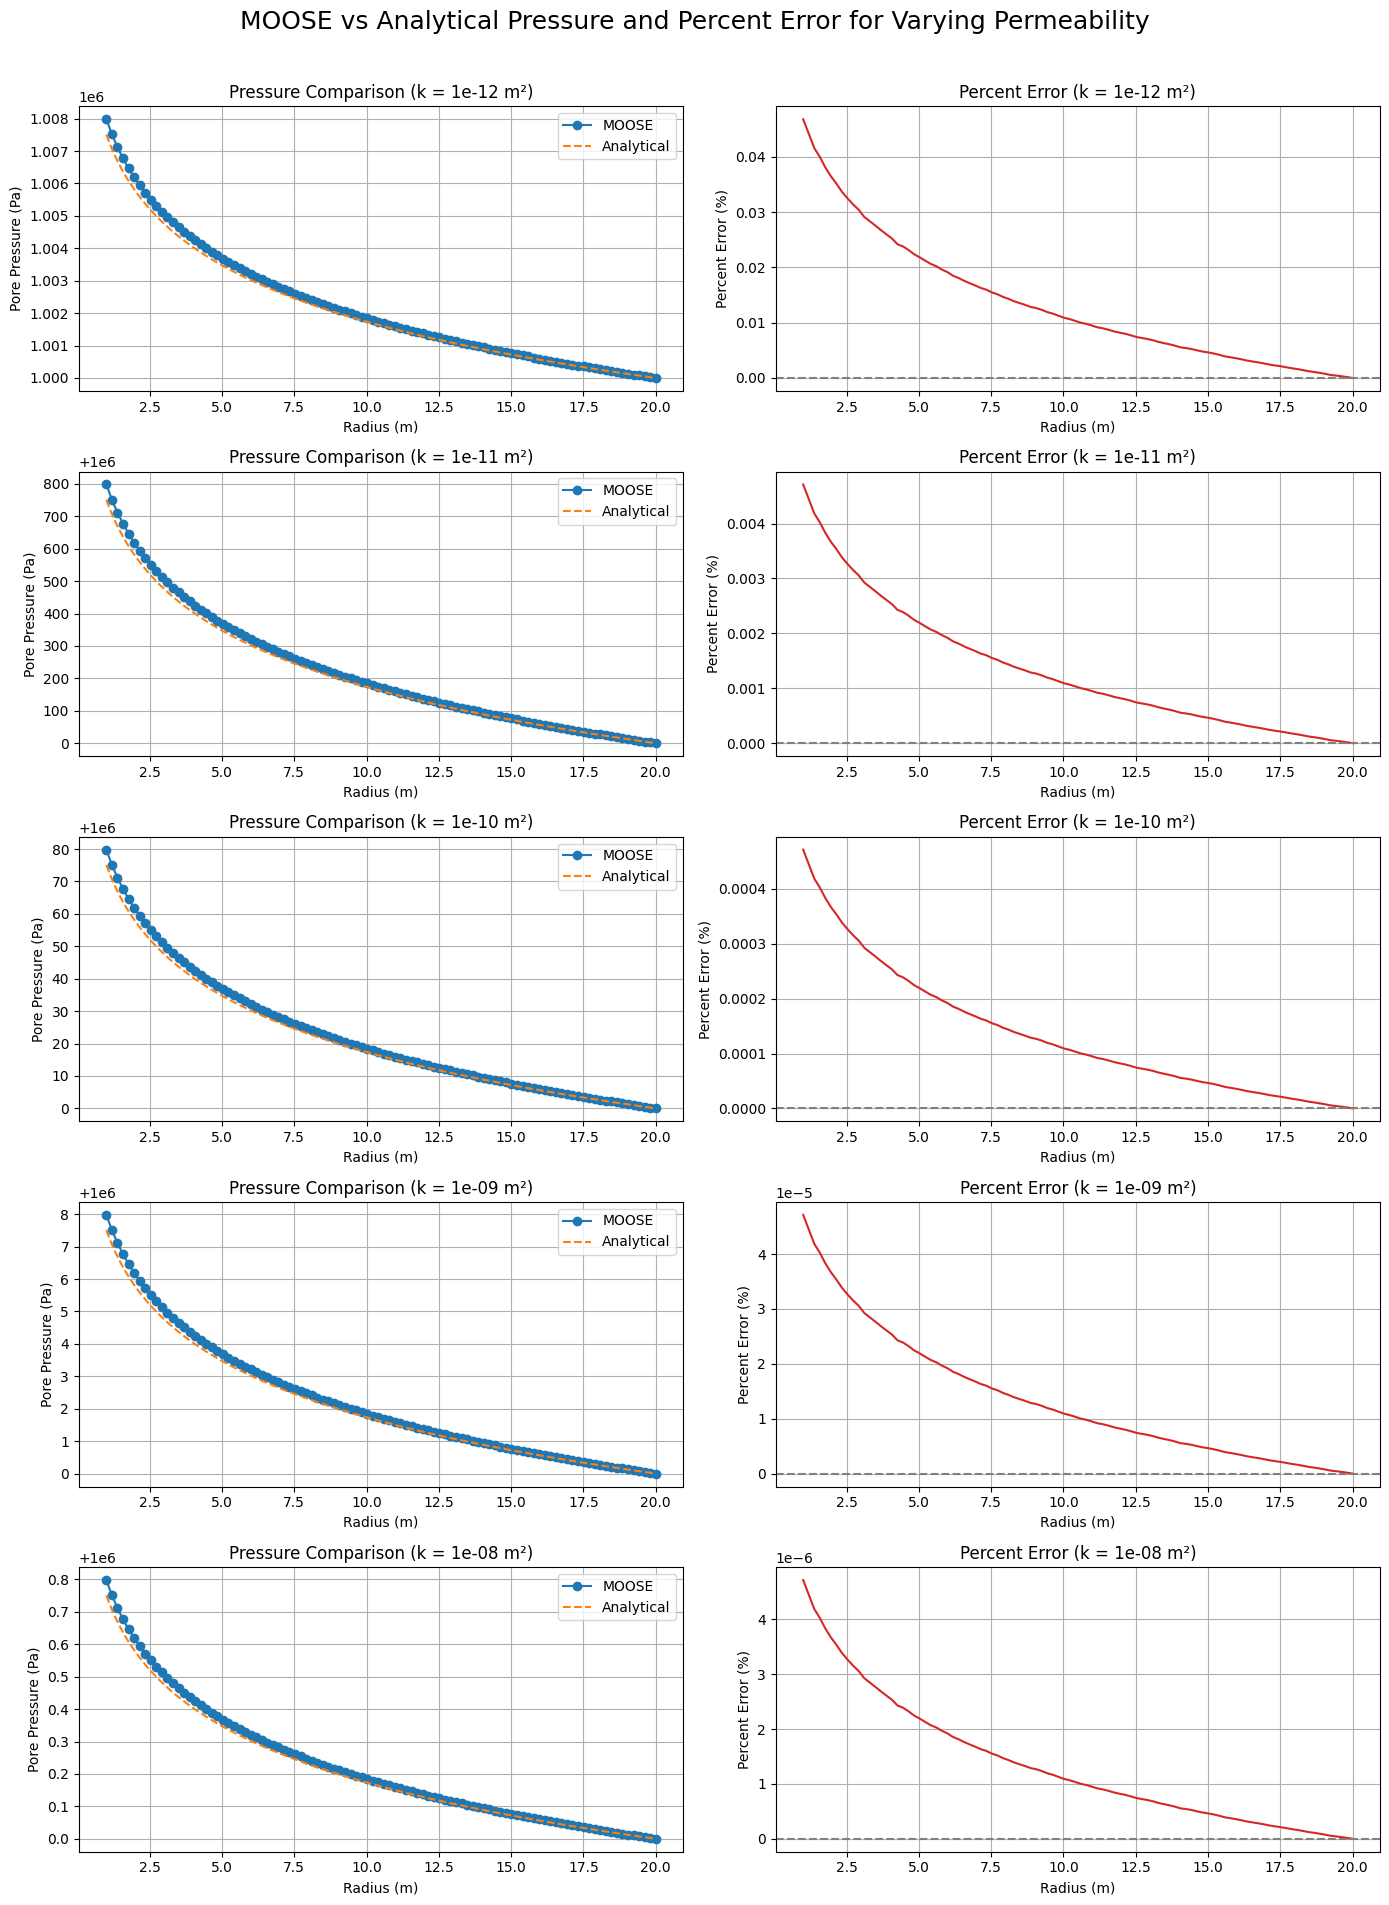

In [ ]:
"""
STEP 1
Project 1
CEE 6755
Tomas Schmieder
"""

# this code shows us the differences between the numerical and analytical pressure vs. radius and then finds the error between them

import os
import subprocess
import shutil
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# constants
mu = 1e-3       # Pa.s
Q = 315e-6      # m^3/s
H = 20          # m
P0 = 1e6        # Pa
R0 = 20.0       # m
Rw = 1        # m

permeabilities = [1e-12, 1e-11, 1e-10, 1e-9, 1e-8]


input_template = "step1.i"
input_file = "step1_tmp.i"
executable = "./borehole1-opt"
output_csv = input_file.replace(".i", "_csv_data_0001.csv")
output_dir = "sim_outputs"
os.makedirs(output_dir, exist_ok=True)


numerical_results = []
analytical_results = []


search_line = "permeability = '1E-12 0 0   0 1E-12 0   0 0 1E-12'"

# looping over the permeabiltiies 
for k in permeabilities:
    with open(input_template, "r") as f:
        input_text = f.read()

    new_perm_line = f"permeability = '{k:.0e} 0 0   0 {k:.0e} 0   0 0 {k:.0e}'"
    input_text = input_text.replace(search_line, new_perm_line)

    with open(input_file, "w") as f:
        f.write(input_text)

    if os.path.exists(output_csv):
        os.remove(output_csv)

    # MOOSE
    subprocess.run([executable, "-i", input_file], check=True)

    result_filename = f"results_k_{k:.0e}.csv"
    result_path = os.path.join(output_dir, result_filename)
    shutil.copy(output_csv, result_path)

    df = pd.read_csv(result_path)
    radius = df["x"].values
    p_numerical = df["porepressure"].values

    R_vals = np.linspace(Rw, R0, 200)
    P_analytical = P0 - ((mu * Q) / (2 * np.pi * k * H)) * np.log(R_vals / R0)

    numerical_results.append((k, radius, p_numerical))
    analytical_results.append((k, R_vals, P_analytical))



# plotting stuff
numerical_results_sorted = sorted(numerical_results, key=lambda x: x[0])
analytical_results_sorted = sorted(analytical_results, key=lambda x: x[0])
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(14, 20))


for i, (k, radius, p_num) in enumerate(numerical_results_sorted):
    # recomputing analytical solution cause the other way doesnt work
    R_vals = np.linspace(Rw, R0, 200)
    P_ana = P0 - ((mu * Q) / (2 * np.pi * k * H)) * np.log(R_vals / R0)

    ax_left = axes[i, 0]
    ax_left.plot(radius, p_num, 'o-', label='MOOSE')
    ax_left.plot(R_vals, P_ana, '--', label='Analytical')
    ax_left.set_title(f"Pressure Comparison (k = {k:.0e} m²)")
    ax_left.set_xlabel("Radius (m)")
    ax_left.set_ylabel("Pore Pressure (Pa)")
    ax_left.grid(True)
    ax_left.legend()

    ax_right = axes[i, 1]
    p_analytical_interp = np.interp(radius, R_vals, P_ana)
    percent_error = 100 * np.abs(p_num - p_analytical_interp) / p_analytical_interp
    ax_right.plot(radius, percent_error, color='tab:red')
    ax_right.axhline(0, color='gray', linestyle='--')
    ax_right.set_title(f"Percent Error (k = {k:.0e} m²)")
    ax_right.set_xlabel("Radius (m)")
    ax_right.set_ylabel("Percent Error (%)")
    ax_right.grid(True)
plt.suptitle("MOOSE vs Analytical Pressure and Percent Error for Varying Permeability", fontsize=18)
plt.tight_layout(rect=[0, 0.03, 1, 0.97])
plt.show()
